# Continual Unlearning Results Visualization for CIFAR-100

This notebook analyzes and visualizes the performance of different continual unlearning methods on the CIFAR-100 dataset. We'll load results from CSV files and compare various methods against the ground truth (retrain_continual_unlearn).

In [32]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [33]:
# Load the data for CIFAR-100
try:
    df = pd.read_csv('eval_results_for_cifar100.csv')
    print(f"Loaded CIFAR-100 data with {df.shape[0]} rows and {df.shape[1]} columns")
    if 'model' not in df.columns:
        print("Warning: 'model' column not found in the CSV. Please ensure it's present for model-specific analysis.")
    if 'classes_forgotten' not in df.columns:
        print("Warning: 'classes_forgotten' column not found. This column is recommended for x-axis in plots.")
except FileNotFoundError:
    print("Error: eval_results_for_cifar100.csv not found. Please generate this file first.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent subsequent errors

# Filter out any methods we want to exclude (if any)
if 'method' in df.columns and not df.empty:
    df = df[~df['method'].isin(['boundary_expanding', 'boundary_shrink'])] # Example filter

Loaded CIFAR-100 data with 304 rows and 316 columns


In [34]:
# Calculate Test Accuracy Gaps vs. Retrain (per model) for CIFAR-100
if not df.empty and 'method' in df.columns and 'model' in df.columns:
    # Use test_accuracy_class_X columns for gap calculation
    acc_cols = [col for col in df.columns if col.startswith("test_accuracy_class_")]
    if not acc_cols:
        print("No 'test_accuracy_class_X' columns found. Skipping gap calculation.")
    else:
        class_indices_str = sorted(list(set([col.split("_")[-1] for col in acc_cols])), key=int)
        class_indices_int = [int(c) for c in class_indices_str]

        retrain_df_base = df[df['method'] == 'retrain']
        all_gap_data_frames = []

        for model_name in df['model'].unique():
            model_df = df[df['model'] == model_name].copy()
            retrain_df_model = retrain_df_base[retrain_df_base['model'] == model_name]
            gap_data_model = {}

            if retrain_df_model.empty:
                print(f"No 'retrain' data found for model {model_name}. Skipping gap calculation for this model.")
                continue

            # Group by 'forget_class_end' or 'classes_forgotten' to match baselines
            # Using 'forget_class_end' as it's more directly tied to class indices
            for end_idx_val in sorted(retrain_df_model.forget_class_end.unique()):
                tmp_retrain_end_idx_df = retrain_df_model[retrain_df_model.forget_class_end == end_idx_val]
                if tmp_retrain_end_idx_df.empty:
                    continue
                
                baseline_values_for_model_end_idx = {}
                for class_idx_s in class_indices_str:
                    col_name = f'test_accuracy_class_{class_idx_s}'
                    if col_name in tmp_retrain_end_idx_df.columns:
                        baseline_values_for_model_end_idx[class_idx_s] = tmp_retrain_end_idx_df[col_name].mean() # Use mean if multiple retrain runs for same end_idx

                mask = (model_df.forget_class_end == end_idx_val)
                for class_idx_s in class_indices_str:
                    if class_idx_s in baseline_values_for_model_end_idx:
                        baseline_value = baseline_values_for_model_end_idx[class_idx_s]
                        current_col_name = f'test_accuracy_class_{class_idx_s}'
                        gap_column_name = f'gap_class_{class_idx_s}' # Generic gap prefix
                        
                        if gap_column_name not in gap_data_model:
                            gap_data_model[gap_column_name] = pd.Series(index=model_df.index, dtype=float)
                        
                        if current_col_name in model_df.columns:
                            gap_data_model[gap_column_name].loc[mask] = model_df.loc[mask, current_col_name] - baseline_value
            
            if gap_data_model:
                gap_df_model = pd.DataFrame(gap_data_model, index=model_df.index)
                original_model_df_index_name = model_df.index.name
                model_df_reset = model_df.reset_index()
                gap_df_model_reset = gap_df_model.reset_index(drop=True)
                
                model_df_with_gaps = pd.concat([model_df_reset, gap_df_model_reset], axis=1)
                # Restore original index if it was named, or handle default 'index'/'level_0'
                if 'index' in model_df_with_gaps.columns and original_model_df_index_name is not None:
                    model_df_with_gaps = model_df_with_gaps.set_index('index')
                    model_df_with_gaps.index.name = original_model_df_index_name
                elif 'level_0' in model_df_with_gaps.columns and original_model_df_index_name is None: 
                    model_df_with_gaps = model_df_with_gaps.set_index('level_0')
                    model_df_with_gaps.index.name = None
                all_gap_data_frames.append(model_df_with_gaps)

        if all_gap_data_frames:
            df = pd.concat(all_gap_data_frames).reset_index(drop=True) # Reset index after concat if models had different indices
            gap_cols_overall = [col for col in df.columns if col.startswith('gap_class_')]
            df[gap_cols_overall] = df[gap_cols_overall].fillna(np.nan)
            print("Gap calculations for test accuracies complete.")
            print(df[[col for col in df.columns if 'gap_class_' in col or col in ['method', 'model', 'forget_class_end']]].head())
        else:
            print("No gap data was generated for test accuracies.")
elif df.empty:
    print("DataFrame is empty. Cannot perform gap calculations for test accuracies.")
else:
    print("DataFrame does not contain 'method' or 'model' columns. Cannot perform model-specific gap calculations for test accuracies.")

Gap calculations for test accuracies complete.
  method     model  forget_class_end  gap_class_0  gap_class_1  gap_class_2  \
0     FT  resnet18                 4          0.0          0.0          0.0   
1     FT  resnet18                 9          0.0          0.0          0.0   
2     FT  resnet18                14          0.0          0.0          0.0   
3     FT  resnet18                19          0.0          0.0          0.0   
4     FT  resnet18                24          0.0          0.0          0.0   

   gap_class_3  gap_class_4  gap_class_5  gap_class_6  ...  gap_class_90  \
0          0.0          0.0        -21.0          2.0  ...         -13.0   
1          0.0          0.0          0.0          0.0  ...         -21.0   
2          0.0          0.0          0.0          0.0  ...          -9.0   
3          0.0          0.0          0.0          0.0  ...          -5.0   
4          0.0          0.0          0.0          0.0  ...         -26.0   

   gap_class_91  gap_

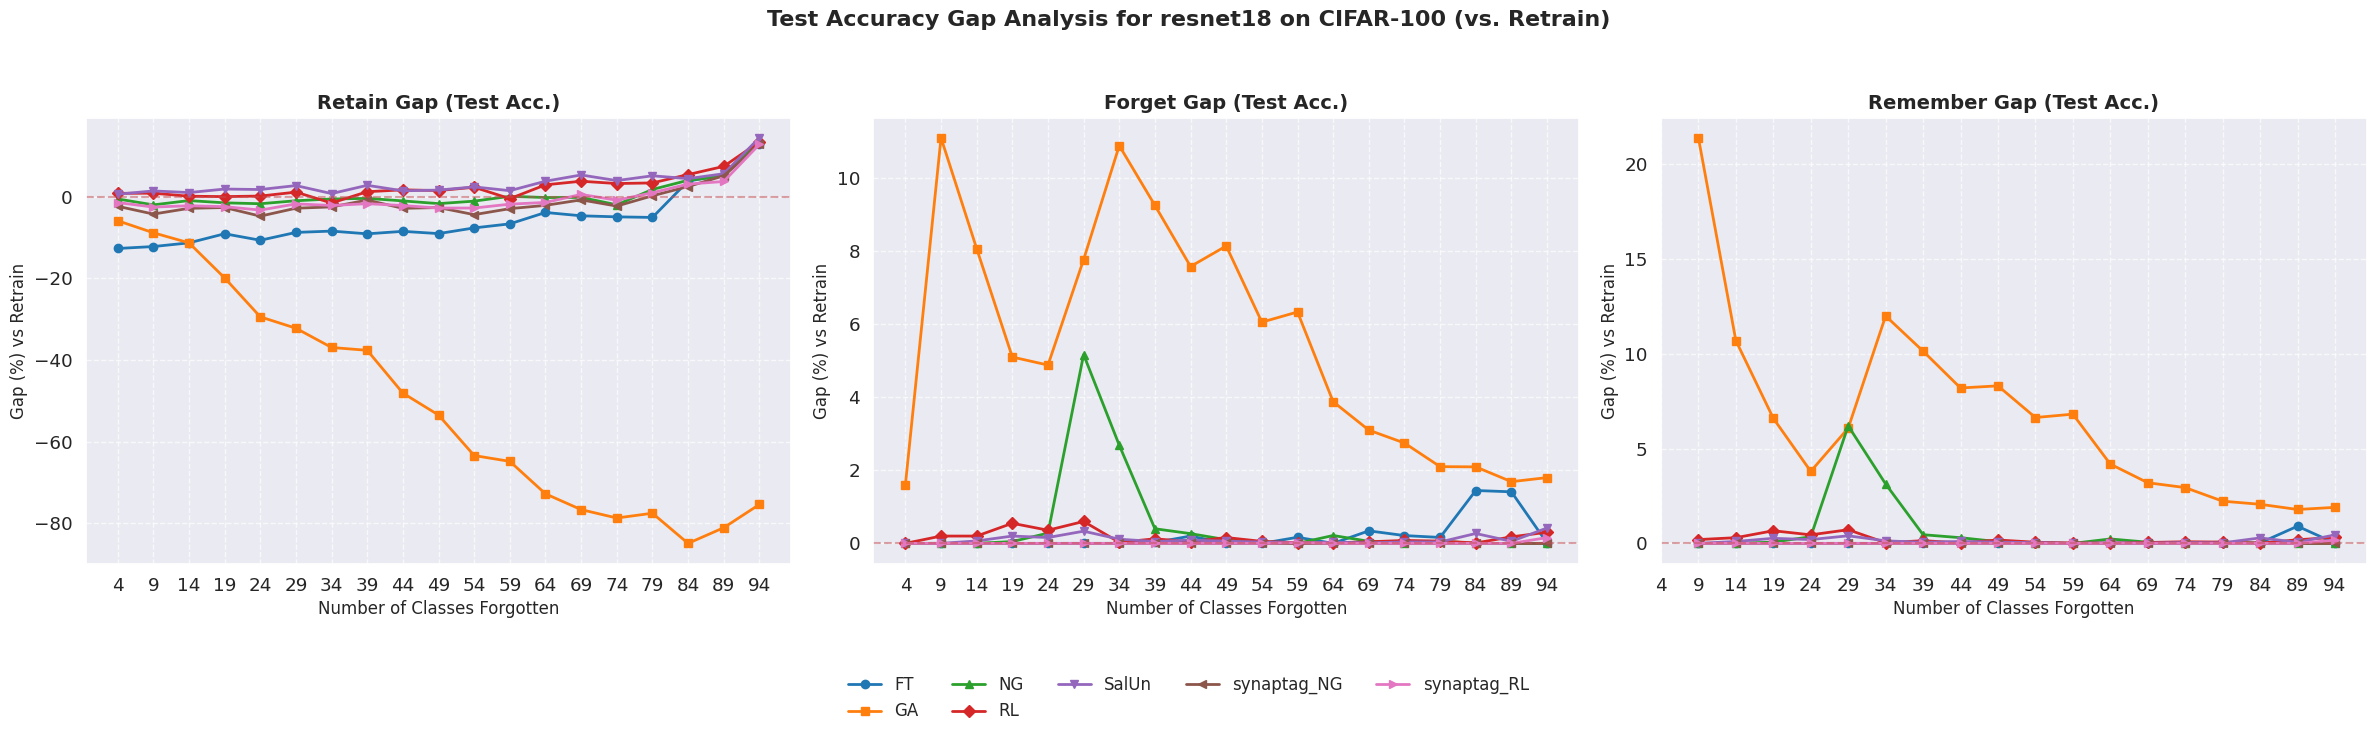

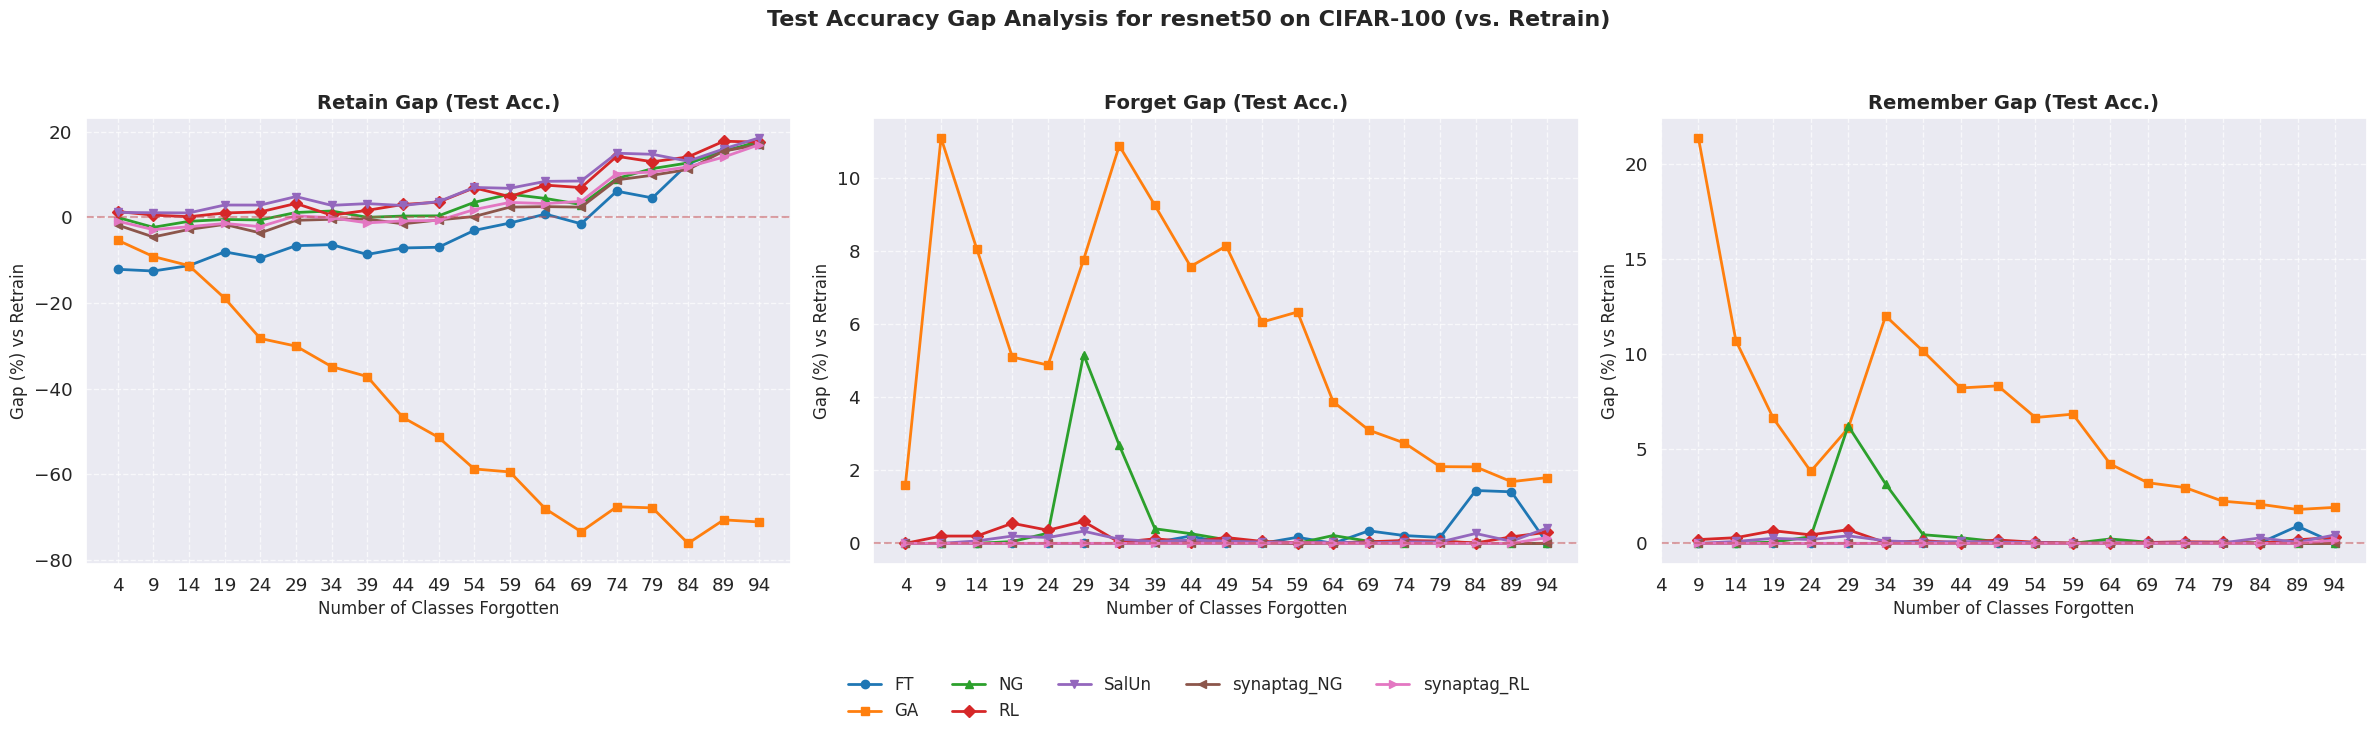

In [35]:
# Visualize Retain, Forget, Remember Gaps for CIFAR-100 (per model, non-LP)
if not df.empty and 'method' in df.columns and 'model' in df.columns and any(col.startswith('gap_class_') for col in df.columns):
    results_gap_summary_c100 = []
    num_classes_cifar100 = 100

    for _, row in df.iterrows():
        if pd.isna(row['method']) or pd.isna(row['model']) or pd.isna(row['forget_class_end']) or pd.isna(row.get('forget_class_begin')):
            continue
        model_name = row['model']
        end_idx = int(row['forget_class_end'])
        forget_begin_idx = int(row['forget_class_begin'])

        gap_columns_present = [col for col in row.index if col.startswith('gap_class_') and not pd.isna(row[col])]
        class_indices_from_cols_int = sorted([int(c.split('_')[-1]) for c in gap_columns_present])

        # Retain Gap: classes after the forgotten block
        retain_gap_cols_indices = [c for c in class_indices_from_cols_int if c > end_idx]
        retain_gap_cols_named = [f'gap_class_{i}' for i in retain_gap_cols_indices]
        retain_gap = row[retain_gap_cols_named].mean() if retain_gap_cols_named else np.nan

        # Forget Gap: classes within the forgotten block [forget_begin_idx, end_idx]
        forget_gap_cols_indices = [c for c in class_indices_from_cols_int if forget_begin_idx <= c <= end_idx]
        forget_gap_cols_named = [f'gap_class_{i}' for i in forget_gap_cols_indices]
        forget_gap = row[forget_gap_cols_named].mean() if forget_gap_cols_named else np.nan

        # Remember Gap: classes before the forgotten block
        remember_gap_cols_indices = [c for c in class_indices_from_cols_int if c <= end_idx - 5]
        remember_gap_cols_named = [f'gap_class_{i}' for i in remember_gap_cols_indices]
        remember_gap = row[remember_gap_cols_named].mean() if remember_gap_cols_named else np.nan

        results_gap_summary_c100.append({
            'method': row['method'],
            'model': model_name,
            'forget_class_end': end_idx,
            'classes_forgotten': row.get('classes_forgotten', end_idx - forget_begin_idx + 1), # Use existing or calculate
            'retain_gap': retain_gap,
            'forget_gap': forget_gap,
            'remember_gap': remember_gap
        })

    gap_summary_df_c100 = pd.DataFrame(results_gap_summary_c100).drop_duplicates()

    for model_name_iter in gap_summary_df_c100['model'].unique():
        model_specific_gap_df = gap_summary_df_c100[gap_summary_df_c100['model'] == model_name_iter]
        if model_specific_gap_df.empty:
            print(f"No gap summary data for model {model_name_iter} on CIFAR-100 (non-LP)")
            continue
        
        fig, axs = plt.subplots(1, 3, figsize=(24, 7))
        methods_to_plot = sorted([m for m in model_specific_gap_df['method'].unique() if m != 'retrain'])
        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
        x_axis_col = 'classes_forgotten'

        for i, method_iter in enumerate(methods_to_plot):
            method_data = model_specific_gap_df[model_specific_gap_df['method'] == method_iter].sort_values(x_axis_col)
            if method_data.empty:
                continue
            axs[0].plot(method_data[x_axis_col], method_data['retain_gap'], marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[1].plot(method_data[x_axis_col], method_data['forget_gap'], marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[2].plot(method_data[x_axis_col], method_data['remember_gap'], marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)

        plot_titles = ['Retain Gap (Test Acc.)', 'Forget Gap (Test Acc.)', 'Remember Gap (Test Acc.)']
        ylabels = ['Gap (%) vs Retrain', 'Gap (%) vs Retrain', 'Gap (%) vs Retrain']
        unique_x_values = sorted(model_specific_gap_df[x_axis_col].unique())

        for i_ax in range(3):
            axs[i_ax].set_title(plot_titles[i_ax], fontsize=14, fontweight='bold')
            axs[i_ax].set_xlabel('Number of Classes Forgotten', fontsize=12)
            axs[i_ax].set_ylabel(ylabels[i_ax], fontsize=12)
            axs[i_ax].grid(True, linestyle='--', alpha=0.7)
            axs[i_ax].axhline(y=0, color='r', linestyle='--', alpha=0.5)
            if unique_x_values:
                axs[i_ax].set_xticks(unique_x_values)

        handles, labels = axs[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=min(5, len(handles)), fontsize=12)
        plt.suptitle(f'Test Accuracy Gap Analysis for {model_name_iter} on CIFAR-100 (vs. Retrain)', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        plt.show()
elif df.empty:
    print("DataFrame is empty. Cannot perform gap visualization for test accuracies.")
else:
    print("Gap data for test accuracies not available or 'method'/'model' columns missing. Skipping gap visualization.")

In [36]:
# Function to calculate more precise accuracy metrics for CIFAR-100 dataset
def calculate_accurate_metrics(row):
    """Calculate precise metrics for forgotten, retained, and remembered classes for CIFAR-100"""
    try:
        if pd.isna(row.get('forget_class_begin')) or pd.isna(row.get('forget_class_end')):
            # Return NaNs if essential keys are missing
            return pd.Series({'end_class_accuracy': np.nan, 'precise_retain_accuracy': np.nan, 'precise_remember_accuracy': np.nan,
                               'end_class_accuracy_test': np.nan, 'precise_retain_accuracy_test': np.nan, 'precise_remember_accuracy_test': np.nan})
        
        forget_class_begin = int(row['forget_class_begin'])
        forget_class_end = int(row['forget_class_end'])
        num_classes = 100  # CIFAR-100 has 100 classes
        
        # Determine prefixes for train and test accuracy columns
        train_prefix = None
        if any(f'train_accuracy_class_{i}' in row for i in range(num_classes)):
            train_prefix = 'train_accuracy_class_'
        elif any(f'accuracy_class_{i}' in row for i in range(num_classes)): # Fallback if only 'accuracy_class_' is present
             train_prefix = 'accuracy_class_'
        
        test_prefix = 'test_accuracy_class_' if any(f'test_accuracy_class_{i}' in row for i in range(num_classes)) else None
        
        result = {}

        # Train metrics
        if train_prefix:
            forget_classes_train = [f'{train_prefix}{i}' for i in range(forget_class_begin, forget_class_end + 1) if f'{train_prefix}{i}' in row and pd.notna(row[f'{train_prefix}{i}'])]
            retained_classes_train = [f'{train_prefix}{i}' for i in range(forget_class_end + 1, num_classes) if f'{train_prefix}{i}' in row and pd.notna(row[f'{train_prefix}{i}'])]
            remembered_classes_train = [f'{train_prefix}{i}' for i in range(0, forget_class_begin) if f'{train_prefix}{i}' in row and pd.notna(row[f'{train_prefix}{i}'])]
            
            result['end_class_accuracy'] = np.mean([row[col] for col in forget_classes_train]) if forget_classes_train else np.nan
            result['precise_retain_accuracy'] = np.mean([row[col] for col in retained_classes_train]) if retained_classes_train else np.nan
            result['precise_remember_accuracy'] = np.mean([row[col] for col in remembered_classes_train]) if remembered_classes_train else np.nan
        else:
            result.update({'end_class_accuracy': np.nan, 'precise_retain_accuracy': np.nan, 'precise_remember_accuracy': np.nan})

        # Test metrics
        if test_prefix:
            forget_classes_test = [f'{test_prefix}{i}' for i in range(forget_class_begin, forget_class_end + 1) if f'{test_prefix}{i}' in row and pd.notna(row[f'{test_prefix}{i}'])]
            retained_classes_test = [f'{test_prefix}{i}' for i in range(forget_class_end + 1, num_classes) if f'{test_prefix}{i}' in row and pd.notna(row[f'{test_prefix}{i}'])]
            remembered_classes_test = [f'{test_prefix}{i}' for i in range(0, forget_class_begin) if f'{test_prefix}{i}' in row and pd.notna(row[f'{test_prefix}{i}'])]
            
            result['end_class_accuracy_test'] = np.mean([row[col] for col in forget_classes_test]) if forget_classes_test else np.nan
            result['precise_retain_accuracy_test'] = np.mean([row[col] for col in retained_classes_test]) if retained_classes_test else np.nan
            result['precise_remember_accuracy_test'] = np.mean([row[col] for col in remembered_classes_test]) if remembered_classes_test else np.nan
        else:
            result.update({'end_class_accuracy_test': np.nan, 'precise_retain_accuracy_test': np.nan, 'precise_remember_accuracy_test': np.nan})
            
        return pd.Series(result)
    except Exception as e: # Catch any other unexpected error during processing
        print(f"Error processing row with data {row.get('method', 'N/A')}, {row.get('model', 'N/A')}, end_idx {row.get('forget_class_end', 'N/A')}: {e}")
        return pd.Series({'end_class_accuracy': np.nan, 'precise_retain_accuracy': np.nan, 'precise_remember_accuracy': np.nan,
                           'end_class_accuracy_test': np.nan, 'precise_retain_accuracy_test': np.nan, 'precise_remember_accuracy_test': np.nan})

# Check if we have the necessary columns to calculate metrics
if not df.empty and ('forget_class_begin' in df.columns and 'forget_class_end' in df.columns):
    # Apply the function to calculate the new metrics
    additional_metrics = df.apply(calculate_accurate_metrics, axis=1)
    df = pd.concat([df, additional_metrics], axis=1)
    
    # Display the dataframe with new metrics
    print("\nData with calculated precise metrics (sample):")
    display_cols = ['method', 'model', 'forget_class_begin', 'forget_class_end', 'classes_forgotten', 
                    'end_class_accuracy_test', 'precise_retain_accuracy_test', 'precise_remember_accuracy_test']
    # Filter out columns not present in df for display to avoid KeyError
    display_cols = [col for col in display_cols if col in df.columns]
    if display_cols:
        print(df[display_cols].head())
    else:
        print("Required columns for display are missing.")
else:
    print("\n'forget_class_begin' or 'forget_class_end' columns not found. Cannot calculate precise metrics.")


Data with calculated precise metrics (sample):
  method     model  forget_class_begin  forget_class_end  classes_forgotten  \
0     FT  resnet18                   0                 4                  4   
1     FT  resnet18                   0                 9                  9   
2     FT  resnet18                   0                14                 14   
3     FT  resnet18                   0                19                 19   
4     FT  resnet18                   0                24                 24   

   end_class_accuracy_test  precise_retain_accuracy_test  \
0                      0.0                     63.547368   
1                      0.0                     63.722222   
2                      0.0                     65.552941   
3                      0.0                     67.987500   
4                      0.0                     66.706667   

   precise_remember_accuracy_test  
0                             NaN  
1                             NaN  
2       

In [37]:
# Compare reported vs calculated metrics (if we have calculated metrics)
if not df.empty and 'precise_retain_accuracy_test' in df.columns and 'accuracy_retain' in df.columns and 'end_class_accuracy_test' in df.columns and 'accuracy_forget' in df.columns:
    comparison_df = df[['method', 'model', 'forget_class_end', 'accuracy_retain', 'precise_retain_accuracy_test', 
                       'accuracy_forget', 'end_class_accuracy_test']].copy()
    
    # Calculate difference between reported and calculated metrics
    comparison_df['retain_diff'] = comparison_df['accuracy_retain'] - comparison_df['precise_retain_accuracy_test']
    comparison_df['forget_diff'] = comparison_df['accuracy_forget'] - comparison_df['end_class_accuracy_test']
    
    print("Average difference in retain accuracy (reported vs calculated test):")
    print(comparison_df.groupby('model')['retain_diff'].mean())
    print("\nAverage difference in forget accuracy (reported vs calculated test):")
    print(comparison_df.groupby('model')['forget_diff'].mean())
    
    # Display comparison table for a sample model if data exists
    if not comparison_df.empty and 'model' in comparison_df.columns:
        sample_model = comparison_df['model'].unique()[0] if len(comparison_df['model'].unique()) > 0 else None
        if sample_model:
            print(f"\nComparison for model: {sample_model}")
            display(comparison_df[comparison_df['model'] == sample_model].head(10))
        else:
            print("No models found for comparison display.")
    elif comparison_df.empty:
        print("Comparison DataFrame is empty.")
else:
    print("Skipping comparison - one or more required metrics not available (accuracy_retain, precise_retain_accuracy_test, accuracy_forget, end_class_accuracy_test)")

Average difference in retain accuracy (reported vs calculated test):
model
resnet18    15.737601
resnet50    16.121024
Name: retain_diff, dtype: float64

Average difference in forget accuracy (reported vs calculated test):
model
resnet18    0.088622
resnet50    0.088622
Name: forget_diff, dtype: float64

Comparison for model: resnet18


,method,model,forget_class_end,accuracy_retain,precise_retain_accuracy_test,accuracy_forget,end_class_accuracy_test,retain_diff,forget_diff
0,FT,resnet18,4,78.166082,63.547368,0.000000,0.000,14.618713,0.000000
1,FT,resnet18,9,81.595062,63.722222,0.000000,0.000,17.872840,0.000000
2,FT,resnet18,14,83.913725,65.552941,0.000000,0.000,18.360784,0.000000
3,FT,resnet18,19,86.986111,67.987500,0.000000,0.000,18.998611,0.000000
4,FT,resnet18,24,87.161481,66.706667,0.000000,0.000,20.454815,0.000000
5,FT,resnet18,29,86.971429,68.014286,0.000000,0.000,18.957143,0.000000
6,FT,resnet18,34,88.109402,69.061538,0.000000,0.000,19.047863,0.000000
7,FT,resnet18,39,89.411111,68.500000,0.355556,0.025,20.911111,0.330556
8,FT,resnet18,44,91.406061,70.963636,1.688889,0.200,20.442424,1.488889
9,FT,resnet18,49,89.813333,71.200000,0.044444,0.000,18.613333,0.044444


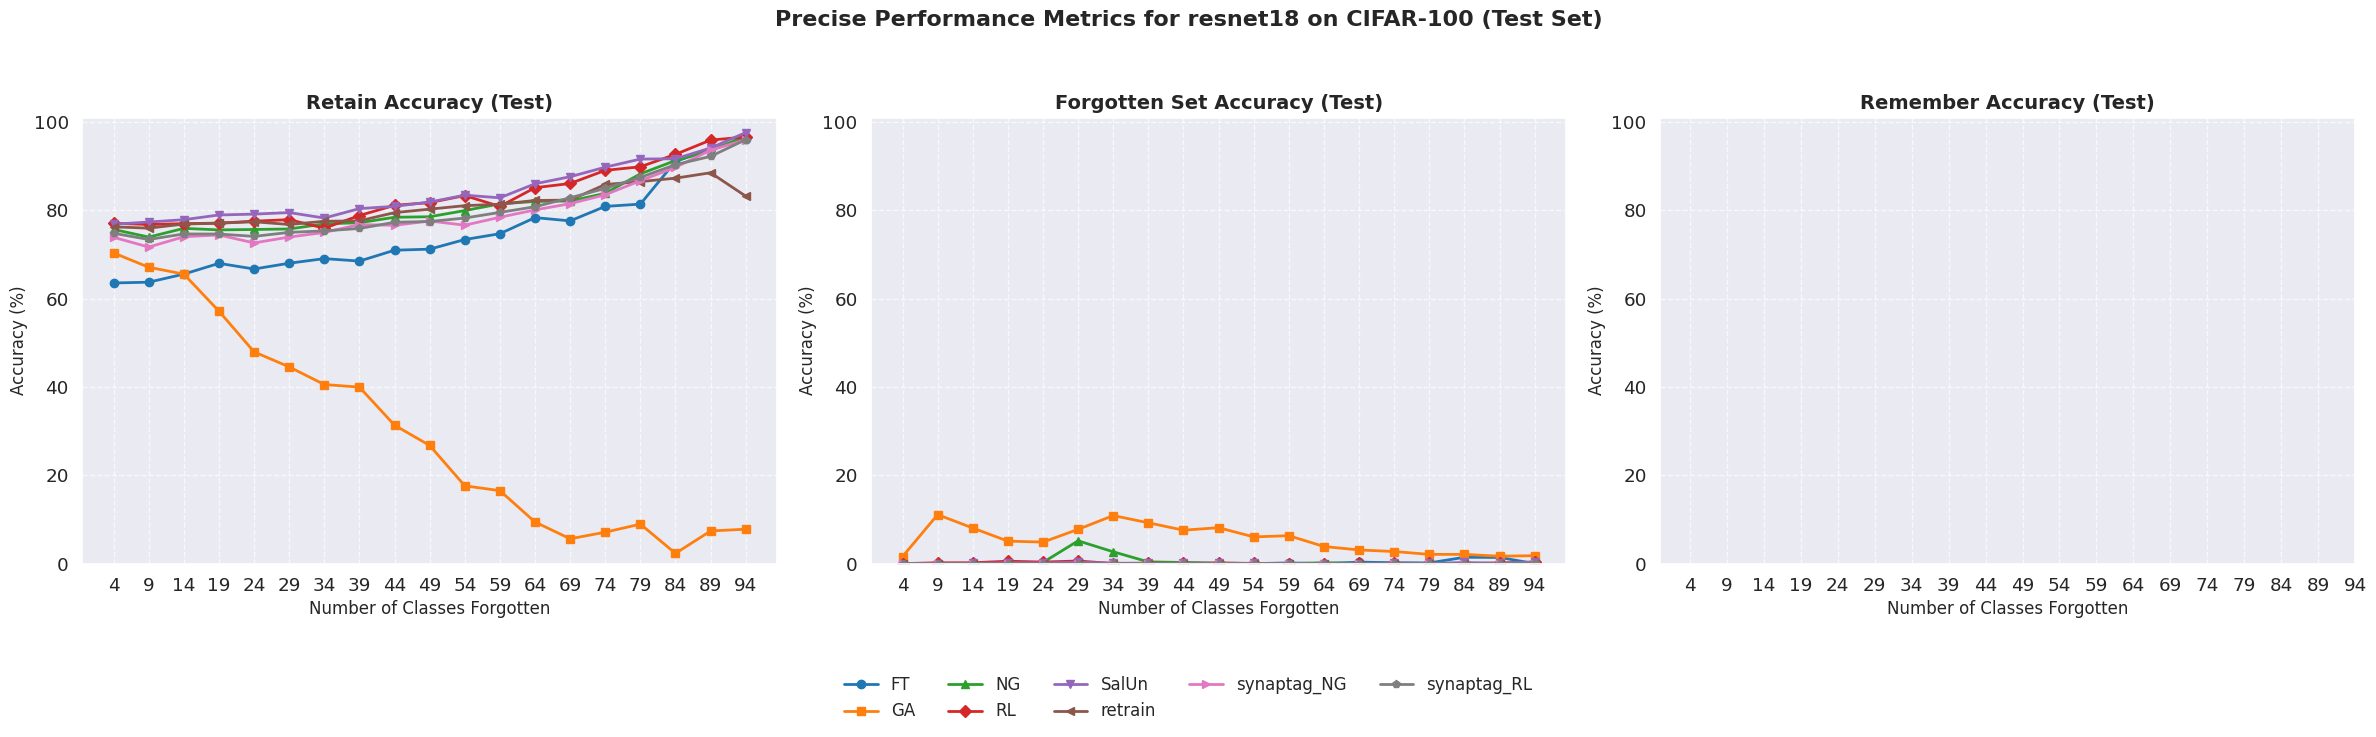

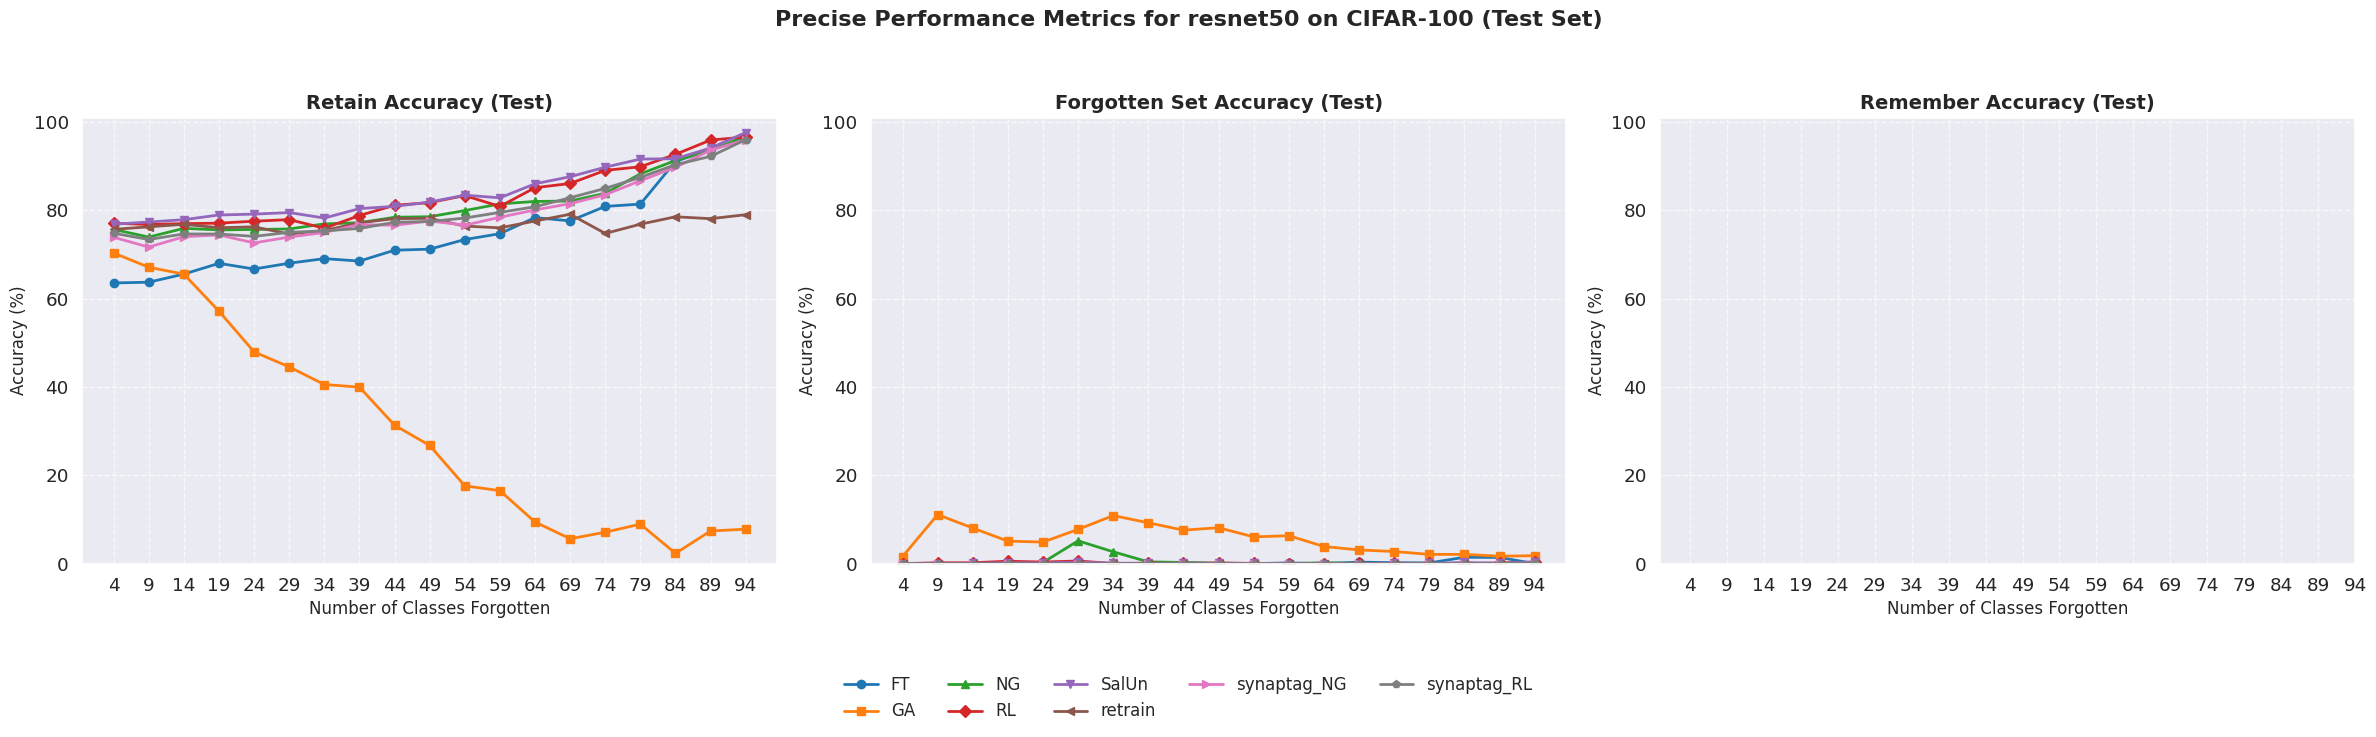

In [38]:
# Visualize the precise metrics for different methods (Test set)
if not df.empty and 'model' in df.columns and \
   all(col in df.columns for col in ['precise_retain_accuracy_test', 'end_class_accuracy_test', 'precise_remember_accuracy_test', 'classes_forgotten']):
    
    for model_name_iter in df['model'].unique():
        model_specific_df = df[df['model'] == model_name_iter]
        if model_specific_df.empty:
            print(f"No data for model {model_name_iter} for precise test metrics on CIFAR-100.")
            continue

        methods_to_plot = sorted(model_specific_df['method'].unique())
        if not methods_to_plot:
            print(f"No methods to plot for model {model_name_iter}.")
            continue

        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
        x_axis_col = 'classes_forgotten'
        
        fig, axs = plt.subplots(1, 3, figsize=(24, 7))
        
        for i, method_iter in enumerate(methods_to_plot):
            method_data = model_specific_df[model_specific_df['method'] == method_iter].sort_values(x_axis_col)
            if method_data.empty:
                continue
            
            axs[0].plot(method_data[x_axis_col], method_data['precise_retain_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[1].plot(method_data[x_axis_col], method_data['end_class_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[2].plot(method_data[x_axis_col], method_data['precise_remember_accuracy_test'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
        
        plot_titles = ['Retain Accuracy (Test)', 'Forgotten Set Accuracy (Test)', 'Remember Accuracy (Test)']
        ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']
        unique_x_values = sorted(model_specific_df[x_axis_col].unique())
        
        for i_ax in range(3):
            axs[i_ax].set_title(plot_titles[i_ax], fontsize=14, fontweight='bold')
            axs[i_ax].set_xlabel('Number of Classes Forgotten', fontsize=12)
            axs[i_ax].set_ylabel(ylabels[i_ax], fontsize=12)
            axs[i_ax].grid(True, linestyle='--', alpha=0.7)
            axs[i_ax].set_ylim(0, 101) # Accuracy typically 0-100
            if unique_x_values:
                axs[i_ax].set_xticks(unique_x_values)
        
        handles, labels = axs[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                      fancybox=True, shadow=True, ncol=min(5, len(handles)), fontsize=12)
        
        plt.suptitle(f'Precise Performance Metrics for {model_name_iter} on CIFAR-100 (Test Set)', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        plt.show()
else:
    print("Not enough data or missing columns for precise test metrics visualization (model, precise_retain_accuracy_test, end_class_accuracy_test, precise_remember_accuracy_test, classes_forgotten).")

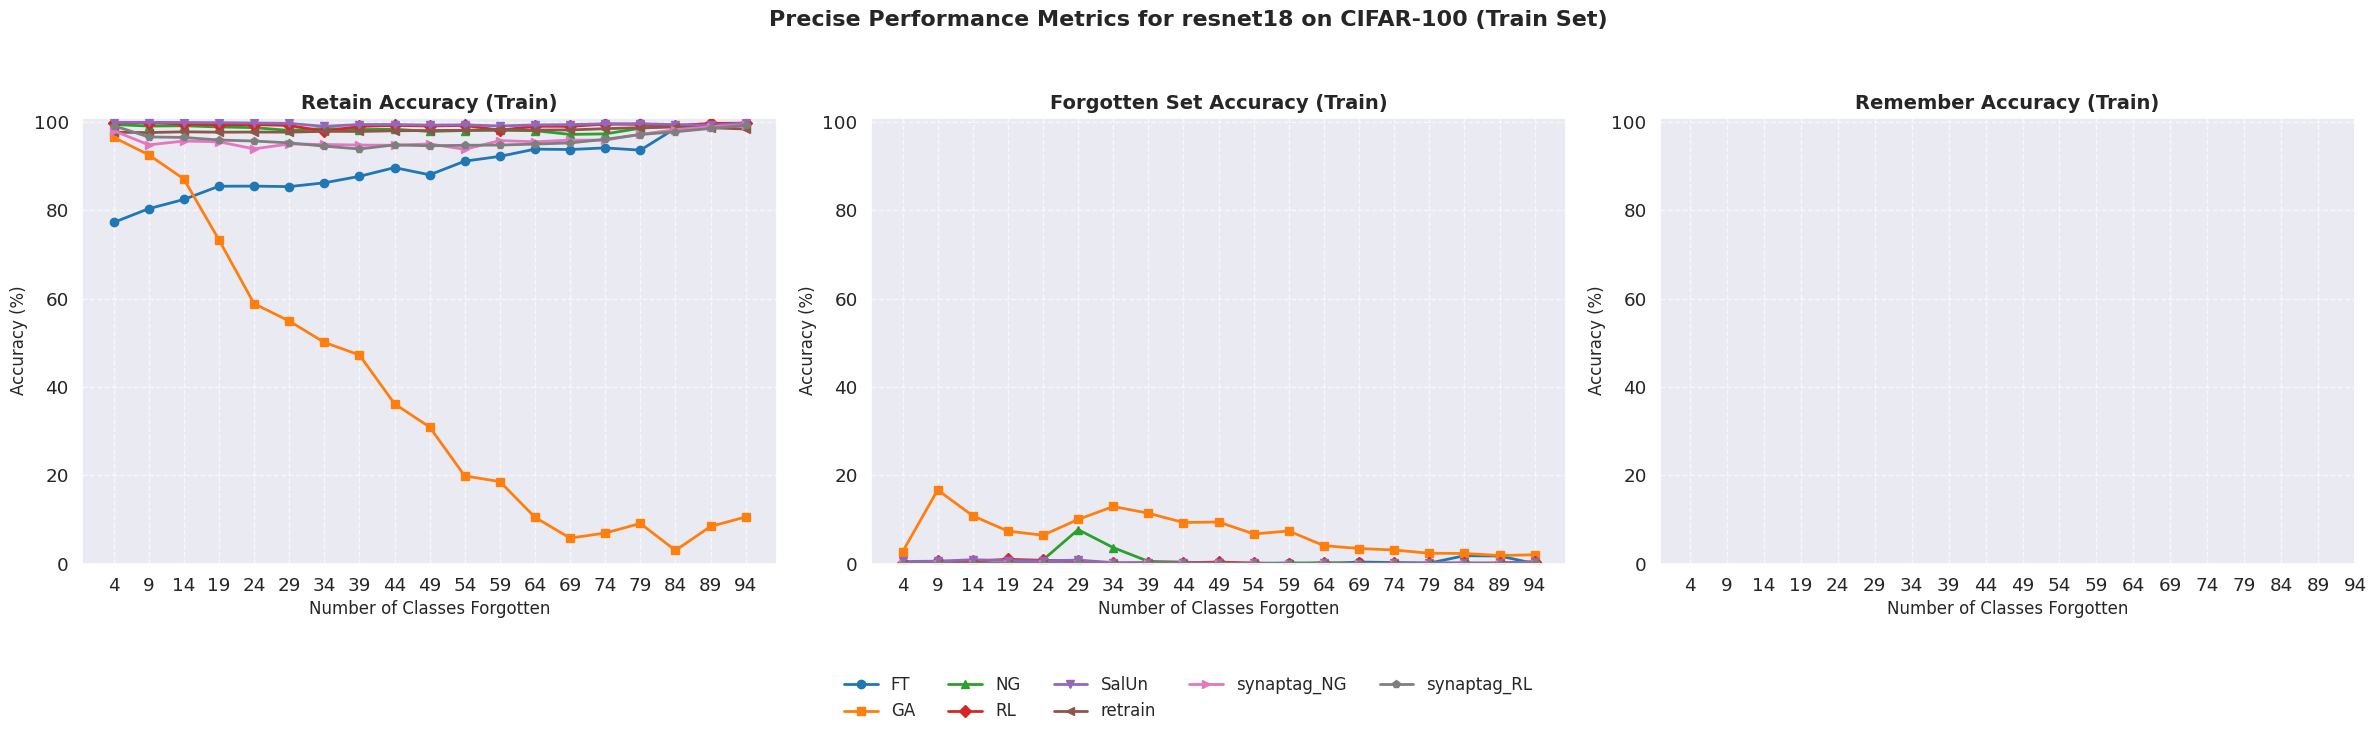

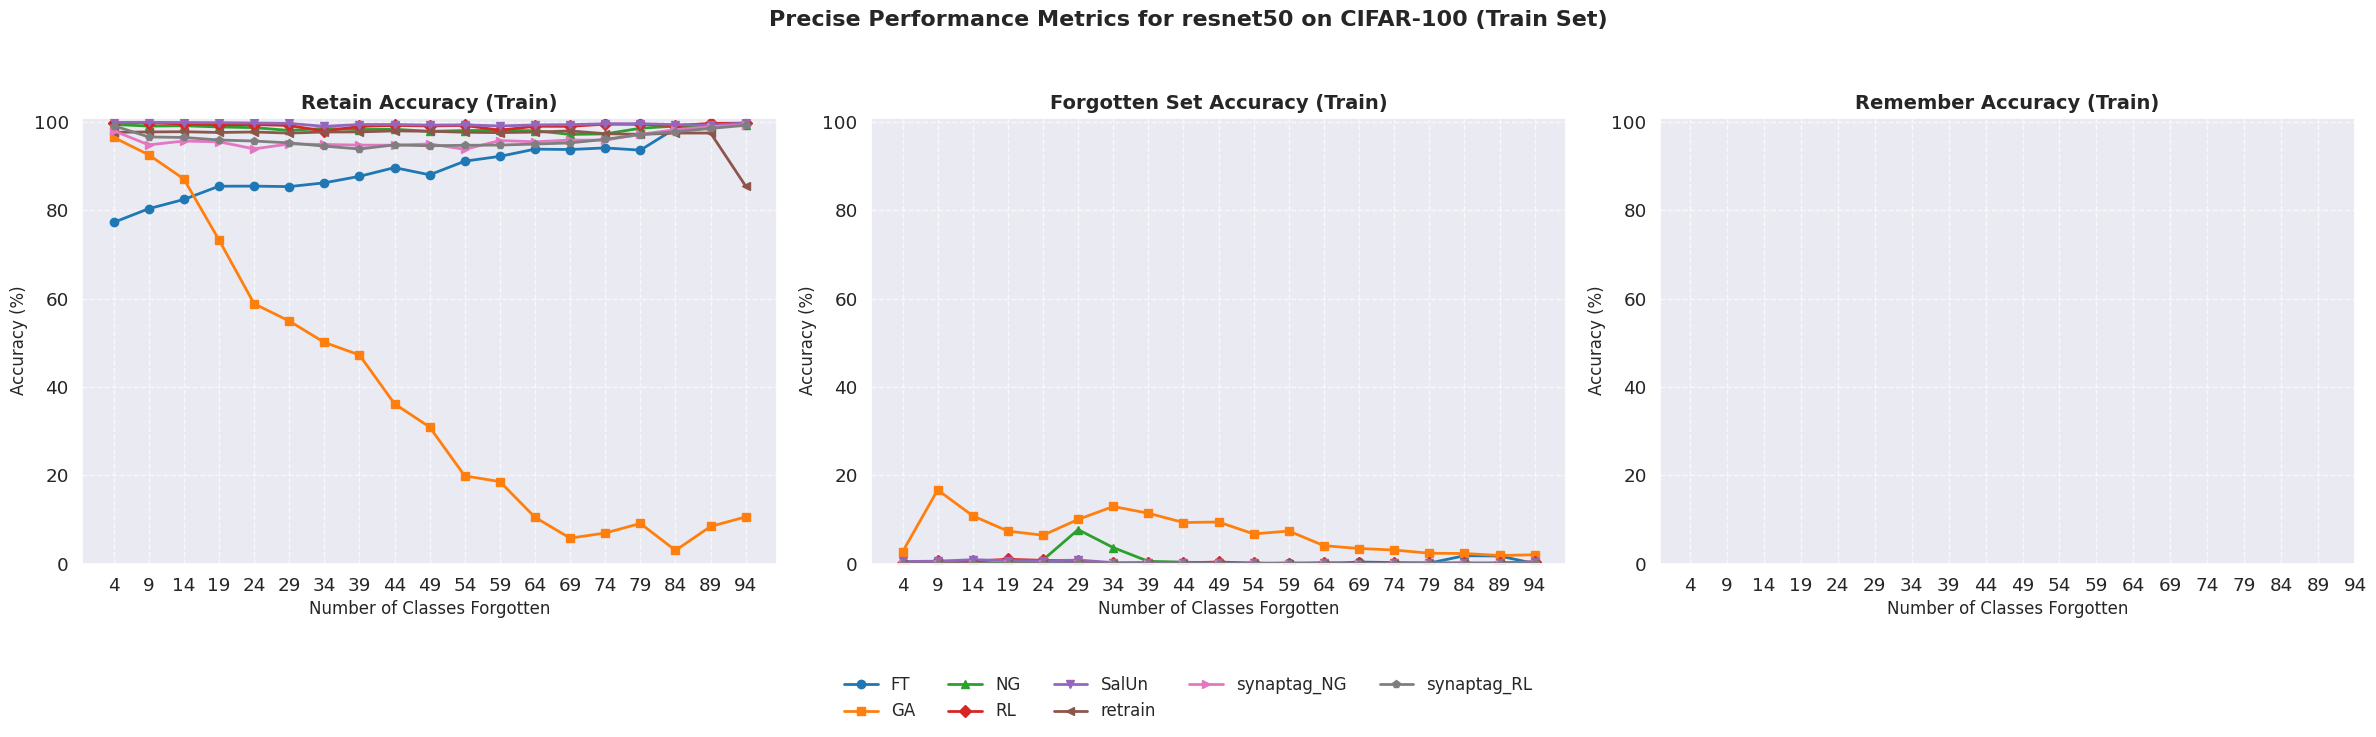

In [39]:
# Visualize the precise metrics for different methods (Train set)
if not df.empty and 'model' in df.columns and \
   all(col in df.columns for col in ['precise_retain_accuracy', 'end_class_accuracy', 'precise_remember_accuracy', 'classes_forgotten']):
    
    for model_name_iter in df['model'].unique():
        model_specific_df = df[df['model'] == model_name_iter]
        if model_specific_df.empty:
            print(f"No data for model {model_name_iter} for precise train metrics on CIFAR-100.")
            continue

        methods_to_plot = sorted(model_specific_df['method'].unique())
        if not methods_to_plot:
            print(f"No methods to plot for model {model_name_iter}.")
            continue

        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
        x_axis_col = 'classes_forgotten'
        
        fig, axs = plt.subplots(1, 3, figsize=(24, 7))
        
        for i, method_iter in enumerate(methods_to_plot):
            method_data = model_specific_df[model_specific_df['method'] == method_iter].sort_values(x_axis_col)
            if method_data.empty:
                continue
            
            axs[0].plot(method_data[x_axis_col], method_data['precise_retain_accuracy'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[1].plot(method_data[x_axis_col], method_data['end_class_accuracy'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
            axs[2].plot(method_data[x_axis_col], method_data['precise_remember_accuracy'], 
                        marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
        
        plot_titles = ['Retain Accuracy (Train)', 'Forgotten Set Accuracy (Train)', 'Remember Accuracy (Train)']
        ylabels = ['Accuracy (%)', 'Accuracy (%)', 'Accuracy (%)']
        unique_x_values = sorted(model_specific_df[x_axis_col].unique())
        
        for i_ax in range(3):
            axs[i_ax].set_title(plot_titles[i_ax], fontsize=14, fontweight='bold')
            axs[i_ax].set_xlabel('Number of Classes Forgotten', fontsize=12)
            axs[i_ax].set_ylabel(ylabels[i_ax], fontsize=12)
            axs[i_ax].grid(True, linestyle='--', alpha=0.7)
            axs[i_ax].set_ylim(0, 101) # Accuracy typically 0-100
            if unique_x_values:
                axs[i_ax].set_xticks(unique_x_values)
        
        handles, labels = axs[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
                      fancybox=True, shadow=True, ncol=min(5, len(handles)), fontsize=12)
        
        plt.suptitle(f'Precise Performance Metrics for {model_name_iter} on CIFAR-100 (Train Set)', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.08, 1, 0.95])
        plt.show()
else:
    print("Not enough data or missing columns for precise train metrics visualization (model, precise_retain_accuracy, end_class_accuracy, precise_remember_accuracy, classes_forgotten).")

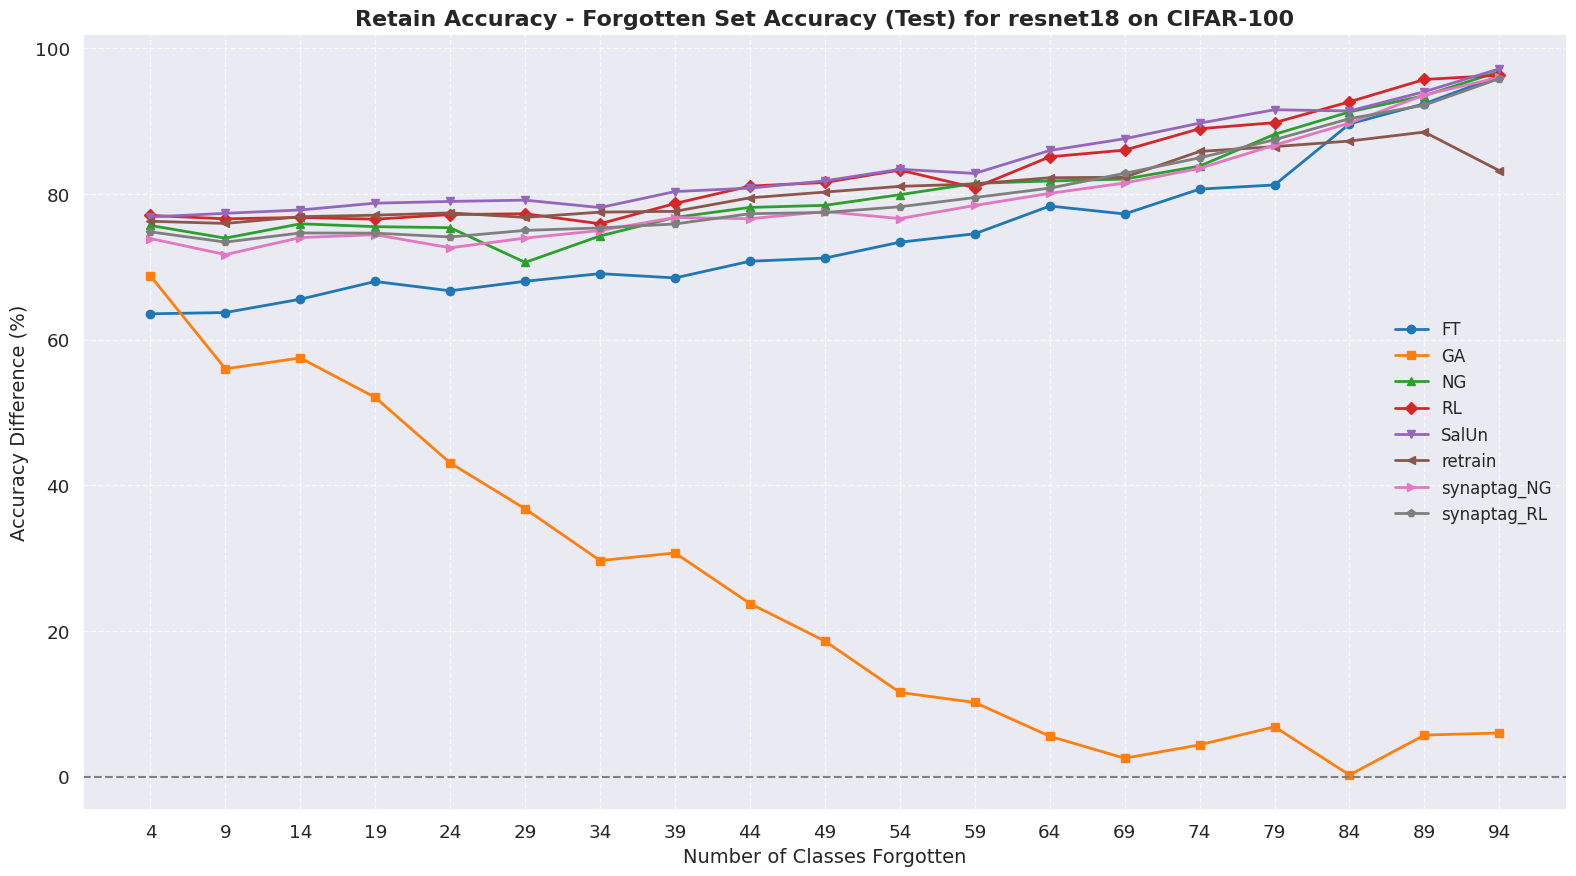

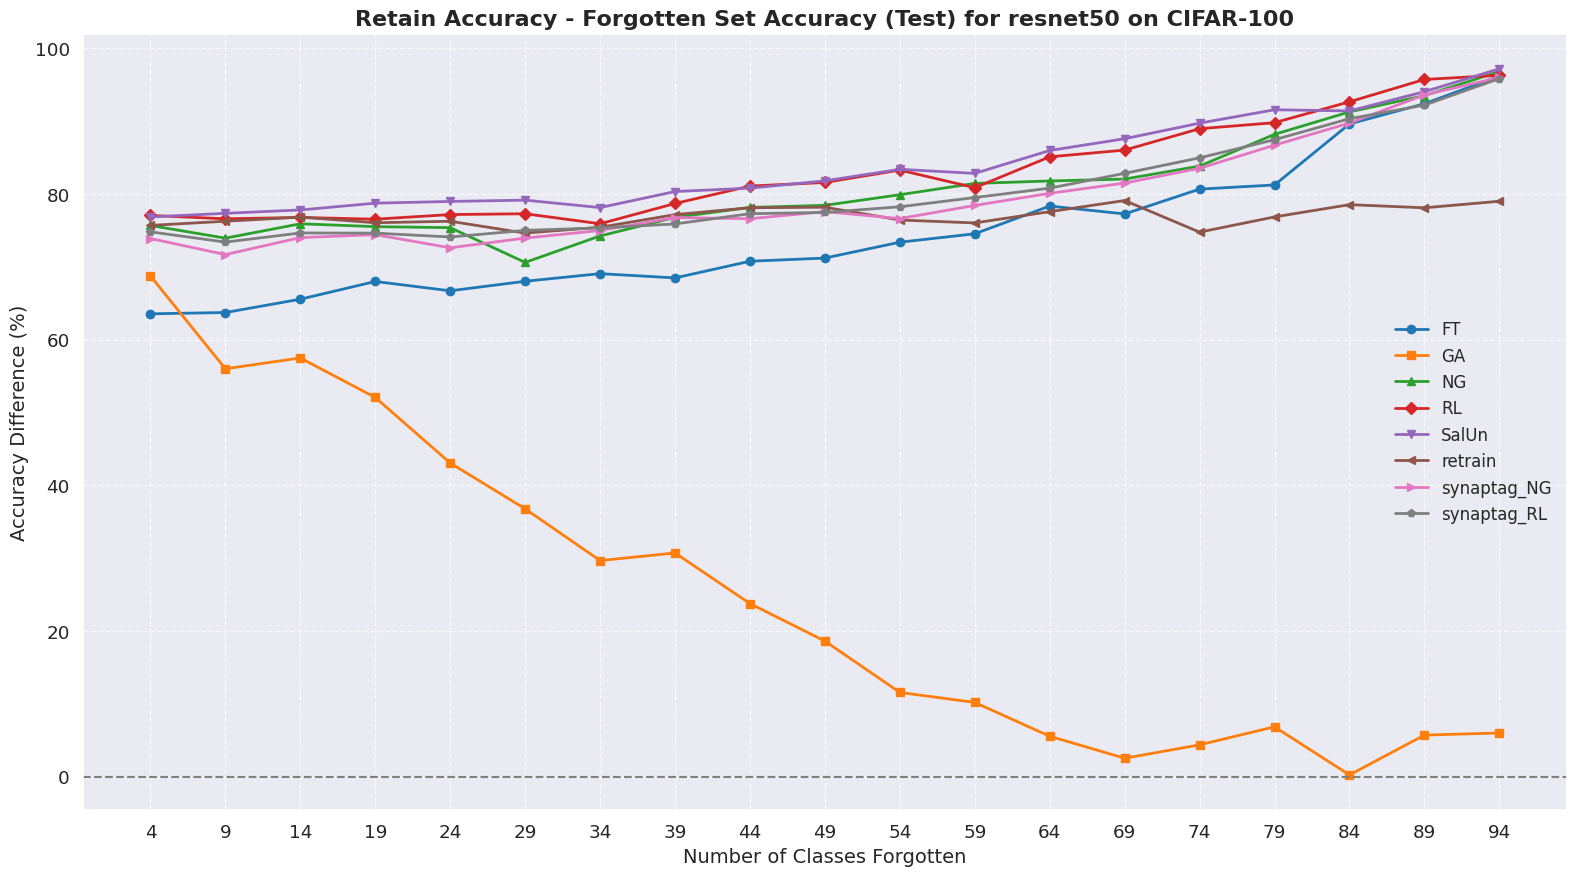

In [40]:
# Calculate and plot the Retain-Forget difference (using Test metrics)
if not df.empty and 'model' in df.columns and \
   all(col in df.columns for col in ['end_class_accuracy_test', 'precise_retain_accuracy_test', 'classes_forgotten']):
    
    df['retain_minus_forget_test_gap'] = df['precise_retain_accuracy_test'] - df['end_class_accuracy_test']
    
    for model_name_iter in df['model'].unique():
        model_specific_df = df[df['model'] == model_name_iter]
        if model_specific_df.empty or 'retain_minus_forget_test_gap' not in model_specific_df.columns:
            print(f"No data or retain_minus_forget_test_gap column missing for model {model_name_iter}.")
            continue

        methods_to_plot = sorted(model_specific_df['method'].unique())
        if not methods_to_plot:
            print(f"No methods to plot for model {model_name_iter}.")
            continue
            
        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
        x_axis_col = 'classes_forgotten'
        
        plt.figure(figsize=(16, 9))
        
        for i, method_iter in enumerate(methods_to_plot):
            method_data = model_specific_df[model_specific_df['method'] == method_iter].sort_values(x_axis_col)
            if method_data.empty:
                continue
            
            plt.plot(method_data[x_axis_col], method_data['retain_minus_forget_test_gap'],
                     marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
        
        plt.title(f'Retain Accuracy - Forgotten Set Accuracy (Test) for {model_name_iter} on CIFAR-100', fontsize=16, fontweight='bold')
        plt.xlabel('Number of Classes Forgotten', fontsize=14)
        plt.ylabel('Accuracy Difference (%)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        plt.axhline(y=0, color='grey', linestyle='--')
        unique_x_values = sorted(model_specific_df[x_axis_col].unique())
        if unique_x_values:
            plt.xticks(unique_x_values)
                
        plt.tight_layout()
        plt.show()
else:
    print("Missing columns required for Retain-Forget difference plot (model, end_class_accuracy_test, precise_retain_accuracy_test, classes_forgotten).")

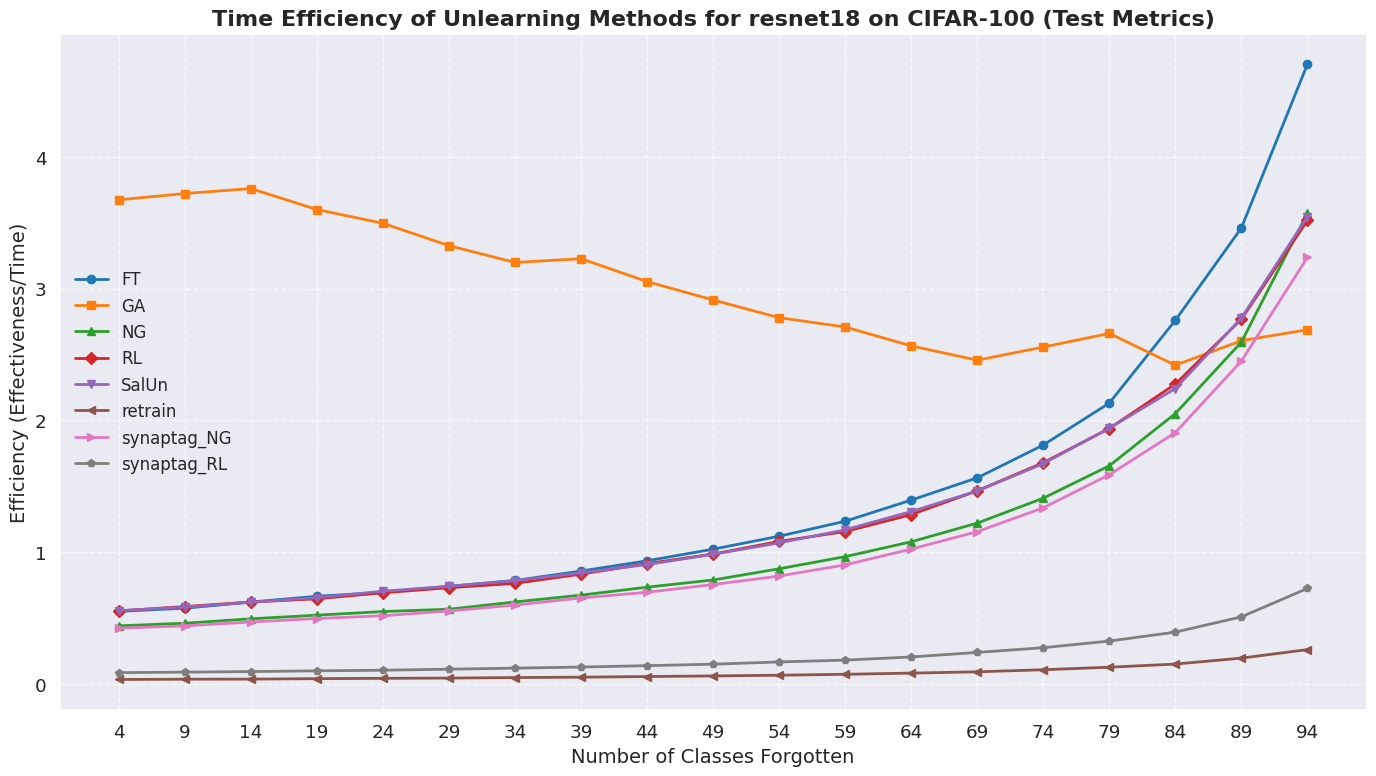

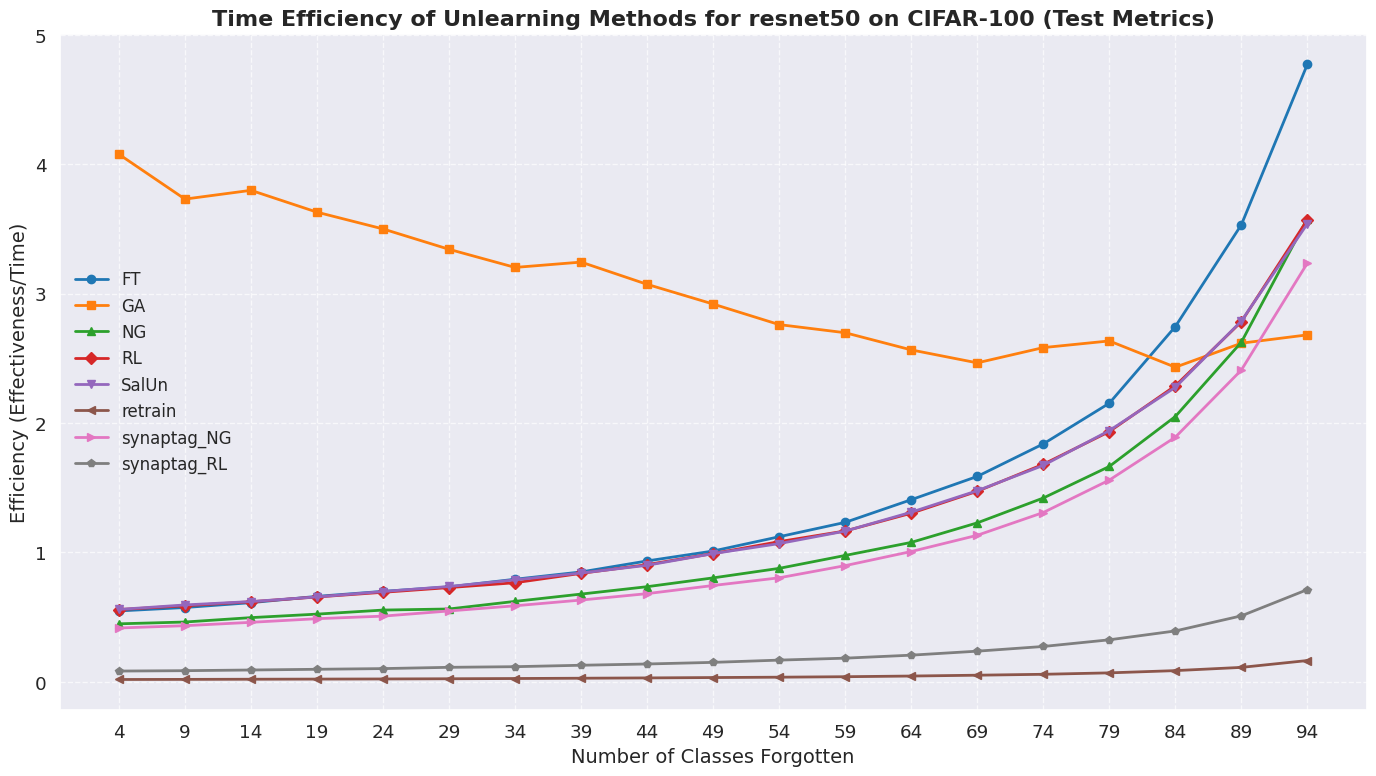

In [41]:
# Compute efficiency metrics: unlearning time vs performance (using Test metrics)
if not df.empty and 'model' in df.columns and \
   all(col in df.columns for col in ['end_class_accuracy_test', 'precise_retain_accuracy_test', 'unlearning_time', 'classes_forgotten']):
    
    def calculate_efficiency_test(row):
        forget_effectiveness = 100 - row['end_class_accuracy_test']
        retain_effectiveness = row['precise_retain_accuracy_test']
        overall_effectiveness = (forget_effectiveness + retain_effectiveness) / 2
        time_efficiency = overall_effectiveness / (row['unlearning_time'] + 1e-10)
        return pd.Series({
            'forget_effectiveness_test': forget_effectiveness,
            'retain_effectiveness_test': retain_effectiveness,
            'overall_effectiveness_test': overall_effectiveness,
            'time_efficiency_test': time_efficiency
        })
    
    efficiency_metrics_test = df.apply(calculate_efficiency_test, axis=1)
    df = pd.concat([df, efficiency_metrics_test], axis=1)
    
    for model_name_iter in df['model'].unique():
        model_specific_df = df[df['model'] == model_name_iter]
        if model_specific_df.empty or 'time_efficiency_test' not in model_specific_df.columns:
            print(f"No data or time_efficiency_test column missing for model {model_name_iter}.")
            continue

        methods_to_plot = sorted(model_specific_df['method'].unique())
        if not methods_to_plot:
            print(f"No methods to plot for model {model_name_iter}.")
            continue

        colors = sns.color_palette("tab10", len(methods_to_plot))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'X']
        x_axis_col = 'classes_forgotten'
        
        plt.figure(figsize=(14, 8))
        
        for i, method_iter in enumerate(methods_to_plot):
            method_data = model_specific_df[model_specific_df['method'] == method_iter].sort_values(x_axis_col)
            if method_data.empty:
                continue
            plt.plot(method_data[x_axis_col], method_data['time_efficiency_test'],
                     marker=markers[i % len(markers)], label=method_iter, color=colors[i % len(colors)], linewidth=2)
        
        plt.title(f'Time Efficiency of Unlearning Methods for {model_name_iter} on CIFAR-100 (Test Metrics)', fontsize=16, fontweight='bold')
        plt.xlabel('Number of Classes Forgotten', fontsize=14)
        plt.ylabel('Efficiency (Effectiveness/Time)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        unique_x_values = sorted(model_specific_df[x_axis_col].unique())
        if unique_x_values:
            plt.xticks(unique_x_values)
        plt.tight_layout()
        plt.show()
else:
    print("Missing columns required for Test Efficiency plot (model, end_class_accuracy_test, precise_retain_accuracy_test, unlearning_time, classes_forgotten).")

In [42]:
# Create a summary table for a specific number of classes_forgotten (using Test metrics)
if not df.empty and 'model' in df.columns and \
   all(col in df.columns for col in ['method', 'unlearning_time', 'end_class_accuracy_test', 
                                   'precise_retain_accuracy_test', 'precise_remember_accuracy_test', 
                                   'retain_minus_forget_test_gap', 'overall_effectiveness_test', 
                                   'time_efficiency_test', 'classes_forgotten']):
    
    if len(df['classes_forgotten'].unique()) > 0:
        unique_x_values = sorted(df['classes_forgotten'].unique())
        # Choose a mid-point for classes_forgotten for the summary table
        mid_idx = len(unique_x_values) // 2
        target_classes_forgotten = unique_x_values[mid_idx] if unique_x_values else None
        
        if target_classes_forgotten is not None:
            summary_df = df[df['classes_forgotten'] == target_classes_forgotten].copy()
            
            if not summary_df.empty:
                summary_columns = ['method', 'model', 'unlearning_time', 'end_class_accuracy_test', 
                                   'precise_retain_accuracy_test', 'precise_remember_accuracy_test', 
                                   'retain_minus_forget_test_gap', 'overall_effectiveness_test', 'time_efficiency_test']
                summary_columns = [col for col in summary_columns if col in summary_df.columns] # Ensure all selected columns exist
                
                summary_df = summary_df[summary_columns].sort_values(['model', 'retain_minus_forget_test_gap'], ascending=[True, False])
                
                column_mapping = {
                    'method': 'Method', 'model': 'Model', 'unlearning_time': 'Time (s)',
                    'end_class_accuracy_test': 'Forget Acc. (Test)',
                    'precise_retain_accuracy_test': 'Retain Acc. (Test)',
                    'precise_remember_accuracy_test': 'Remember Acc. (Test)',
                    'retain_minus_forget_test_gap': 'Retain-Forget Gap (Test)',
                    'overall_effectiveness_test': 'Overall Effectiveness (Test)',
                    'time_efficiency_test': 'Time Efficiency (Test)'
                }
                summary_df.rename(columns=column_mapping, inplace=True)
                
                print(f"\nSummary table for classes_forgotten = {target_classes_forgotten} (Test Metrics, sorted by Model then Retain-Forget Gap):")
                display(summary_df)
            else:
                print(f"No data available for classes_forgotten = {target_classes_forgotten}")
        else:
            print("No unique 'classes_forgotten' values found for summary table.")
    else:
        print("'classes_forgotten' column has no unique values.")
else:
    print("\nMissing columns required for summary table creation using test metrics.")


Summary table for classes_forgotten = 49 (Test Metrics, sorted by Model then Retain-Forget Gap):


,Method,Model,Time (s),Forget Acc. (Test),Retain Acc. (Test),Remember Acc. (Test),Retain-Forget Gap (Test),Overall Effectiveness (Test),Time Efficiency (Test)
104,SalUn,resnet18,92.476065,0.06,81.86,NaN,81.80,90.90,0.982957
123,RL,resnet18,92.194937,0.16,81.74,NaN,81.58,90.79,0.984761
28,retrain,resnet18,1520.356477,0.00,80.26,NaN,80.26,90.13,0.059282
47,NG,resnet18,113.237782,0.10,78.54,NaN,78.44,89.22,0.787900
142,synaptag_NG,resnet18,117.901742,0.00,77.58,NaN,77.58,88.79,0.753085
66,synaptag_RL,resnet18,597.847855,0.00,77.46,NaN,77.46,88.73,0.148416
9,FT,resnet18,83.776906,0.00,71.20,NaN,71.20,85.60,1.021761
85,GA,resnet18,20.354115,8.14,26.76,NaN,18.62,59.31,2.913907
256,SalUn,resnet50,91.732401,0.06,81.86,NaN,81.80,90.90,0.990926
275,RL,resnet50,91.547648,0.16,81.74,NaN,81.58,90.79,0.991724


## Conclusions

This notebook presents an analysis of different continual unlearning methods applied to the CIFAR-100 dataset. The key metrics evaluated include:

1. **Forget Accuracy**: How well the model forgets targeted classes (lower is better)
2. **Retain Accuracy**: How well the model maintains performance on classes it should remember (higher is better)
3. **Remember Accuracy**: How well the model keeps knowledge of earlier seen classes (higher is better)
4. **Retain-Forget Gap**: The difference between retain and forget accuracy (higher is better)
5. **Time Efficiency**: The effectiveness of the unlearning method relative to the computational time required

The Retain-Forget Gap is a particularly useful metric as it captures in a single number how well a method balances the trade-off between forgetting target classes and retaining knowledge of other classes. Methods with a high gap are successfully forgetting what they should while remembering what they should.

The analysis helps identify which methods provide the optimal balance between effective forgetting of specified classes while maintaining accuracy on retained classes, and which methods are most time-efficient.